# Run model on fake data

Here, we generate a synthetic data set for purposes of validating the model constructed in Edward.

In [3]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# we'll want this function below
def softplus(x):
    return np.logaddexp(0, x)

In [5]:
ed.set_seed(12225)

The model is defined by the spike count $N_{us}$ observed when stimulus $s$ is presented to unit $u$:

$$
\begin{align}
N &\sim \mathrm{Poisson}(e^\lambda)  \\
\lambda_{su} &\sim \mathcal{N}(A_{u} + (B \cdot X)_{su}, \sigma^2) \\
\log \sigma &\sim \mathcal{N}(-7, 1^2)
\end{align}
$$
With $X$ an $P \times N_s$ matrix of known regressors, $A$ and $N_u$ vector of baselines, and $(\cdot)_+$ the softplus function: 
$(x)_+ = \log(1 + e^x)$.

In addition, we assume that $A$, $B$, and $C$ are all hierarchically distributed:

$$\begin{align}
A_u &\sim \mathcal{N}(\mu_A, \sigma^2_A) \\
B_{up} &\sim \mathcal{N}(\mu_{Bp}, \sigma^2_{Bp}) \\
\mu_A &\sim \mathcal{N}(\log 25, 0.5^2) \\
\sigma_A &\sim \mathrm{Ga}(2, 4) \\
\mu_{Bp} &\sim \mathcal{N}(0, 0.5^2) \\
\sigma_{Bp} &\sim \mathrm{Ga}(2, 4) \\
\end{align}$$

# Define constants

In [6]:
# basic constants
Nrep = 40  # number of observations per unit per stim
NB = 1000  # number of trials in minibatch
NU = 50  # number of units
NS = 50  # number of stims
P = 3  # number of specified regressors

# Make neural response coefficients

In [7]:
dA = np.log(softplus(25 + 5 * np.random.randn(NU)))  # baseline
dB = np.log(np.array([0.75, 1.2, 1.5]) + 0.1 * np.random.randn(NU, P))  # regressor effects

# Regressors and latent states

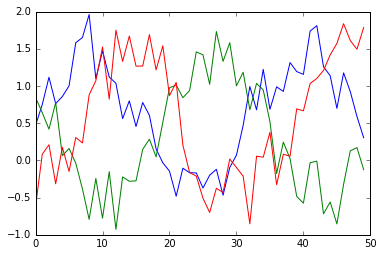

In [8]:
dX = np.sin(np.arange(NS)/5. + 2.5 * np.arange(P)[:, np.newaxis]) + np.random.rand(P, NS)

# plot X
plt.figure()
plt.plot(dX.T);

In [9]:
dX.shape

(3, 50)

In [10]:
evals, evecs = np.linalg.eig(dX.dot(dX.T))
evals
# vvv = evecs.T.dot(dX)
# plt.plot(vvv.T);
# evecs.T

array([ 76.01148779,  17.9540787 ,  26.59600809])

# Generate trial set

In [11]:
dU, dS = np.meshgrid(range(NU), range(NS))
dU = dU.ravel()
dS = dS.ravel()

In [12]:
dU, dS

(array([ 0,  1,  2, ..., 47, 48, 49]), array([ 0,  0,  0, ..., 49, 49, 49]))

In [13]:
dlam_mean = np.tile(dA[dU] + np.sum(dB[dU] * dX[:, dS].T, axis=1), Nrep)

dlam = stats.norm.rvs(loc=dlam_mean, scale=0.01)

In [14]:
dcount = stats.poisson.rvs(np.exp(dlam))
dcount.shape

(100000,)

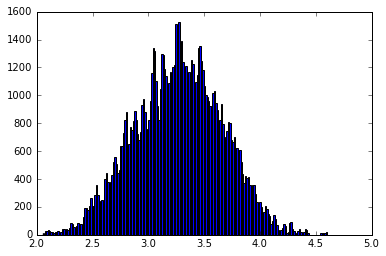

In [15]:
plt.hist(dlam, bins=200);

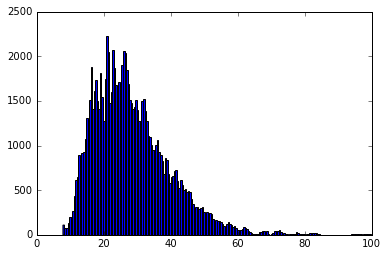

In [16]:
plt.hist(np.exp(dlam), bins=200);

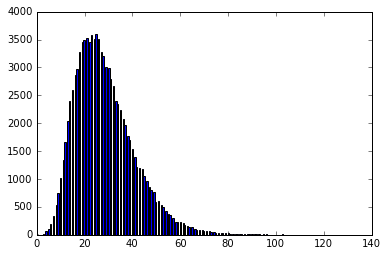

In [17]:
plt.hist(dcount, bins=200);

# Set up data

In [18]:
count = dcount.copy()
Xdat = np.tile(dX[:, dS], (1, Nrep)).T
unit = np.tile(dU, Nrep)
stim = np.tile(dS, Nrep)

Later, we'll need to know the number of observations of each (stim, unit) pair. This is constant for this toy example, but need not be.

In [19]:
pairs = pd.DataFrame({'stim': stim, 'unit': unit, 'count': 1})

In [20]:
# count the number of occurrences of each pair
pair_counts_df_long = pairs.groupby(['stim', 'unit']).sum().reset_index()
pair_counts_df_long.head()

,stim,unit,count
0,0,0,40
1,0,1,40
2,0,2,40
3,0,3,40
4,0,4,40


In [21]:
pair_counts_df = pair_counts_df_long.pivot(values='count', index='stim', columns='unit')
pair_counts_df.head()

unit,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
stim,,,,,,,,,,,,,,,,,,,,,
0,40,40,40,40,40,40,40,40,40,40,...,40,40,40,40,40,40,40,40,40,40
1,40,40,40,40,40,40,40,40,40,40,...,40,40,40,40,40,40,40,40,40,40
2,40,40,40,40,40,40,40,40,40,40,...,40,40,40,40,40,40,40,40,40,40
3,40,40,40,40,40,40,40,40,40,40,...,40,40,40,40,40,40,40,40,40,40
4,40,40,40,40,40,40,40,40,40,40,...,40,40,40,40,40,40,40,40,40,40


In [22]:
pair_counts = pair_counts_df.values

We'd also like to know a unique code for each *possible* (stim, unit) pair. (Some might be missing, but in this case, we still want to code that, since we'll be using these codes to sum over all observations, and the resulting matrix may have some 0 entries, but it must be dense.

We will assume that units and stims are consecutively numbered.

In [23]:
# assuming an array stims x units, these are codes laid out in (C) memory order
# this is necessary so that after aggregating, we can reshape these codes to get
# an NS x NU array
su_codes = NU * stim + unit
su_codes

array([   0,    1,    2, ..., 2497, 2498, 2499])

# GLM

In [24]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
Xdf = pd.DataFrame(Xdat)
Xdf.columns = ['X' + str(c) for c in Xdf.columns]
dta = pd.concat([pd.DataFrame({'count': count, 'unit': unit, 'stim': stim}), Xdf], axis=1)
formula = 'count ~ -1 + C(unit) + C(unit) * (' + '+'.join(Xdf.columns) + ')'
mod = smf.glm(formula=formula, data=dta, family=sm.families.Poisson()).fit()

In [25]:
dta.head(20)

,count,stim,unit,X0,X1,X2
0,29,0,0,0.471434,0.845368,-0.615358
1,18,0,1,0.471434,0.845368,-0.615358
2,17,0,2,0.471434,0.845368,-0.615358
3,21,0,3,0.471434,0.845368,-0.615358
4,29,0,4,0.471434,0.845368,-0.615358
5,20,0,5,0.471434,0.845368,-0.615358
6,19,0,6,0.471434,0.845368,-0.615358
7,20,0,7,0.471434,0.845368,-0.615358
8,21,0,8,0.471434,0.845368,-0.615358
9,16,0,9,0.471434,0.845368,-0.615358


In [26]:
dta.mean()

count    28.450080
stim     24.500000
unit     24.500000
X0        0.704797
X1        0.284299
X2        0.585620
dtype: float64

In [27]:
formula

'count ~ -1 + C(unit) + C(unit) * (X0+X1+X2)'

In [28]:
names = mod.model.exog_names[NU:]
nn = np.array(names)
nn.reshape(P, NU)

array([['X0', 'C(unit)[T.1]:X0', 'C(unit)[T.2]:X0', 'C(unit)[T.3]:X0',
        'C(unit)[T.4]:X0', 'C(unit)[T.5]:X0', 'C(unit)[T.6]:X0',
        'C(unit)[T.7]:X0', 'C(unit)[T.8]:X0', 'C(unit)[T.9]:X0',
        'C(unit)[T.10]:X0', 'C(unit)[T.11]:X0', 'C(unit)[T.12]:X0',
        'C(unit)[T.13]:X0', 'C(unit)[T.14]:X0', 'C(unit)[T.15]:X0',
        'C(unit)[T.16]:X0', 'C(unit)[T.17]:X0', 'C(unit)[T.18]:X0',
        'C(unit)[T.19]:X0', 'C(unit)[T.20]:X0', 'C(unit)[T.21]:X0',
        'C(unit)[T.22]:X0', 'C(unit)[T.23]:X0', 'C(unit)[T.24]:X0',
        'C(unit)[T.25]:X0', 'C(unit)[T.26]:X0', 'C(unit)[T.27]:X0',
        'C(unit)[T.28]:X0', 'C(unit)[T.29]:X0', 'C(unit)[T.30]:X0',
        'C(unit)[T.31]:X0', 'C(unit)[T.32]:X0', 'C(unit)[T.33]:X0',
        'C(unit)[T.34]:X0', 'C(unit)[T.35]:X0', 'C(unit)[T.36]:X0',
        'C(unit)[T.37]:X0', 'C(unit)[T.38]:X0', 'C(unit)[T.39]:X0',
        'C(unit)[T.40]:X0', 'C(unit)[T.41]:X0', 'C(unit)[T.42]:X0',
        'C(unit)[T.43]:X0', 'C(unit)[T.44]:X0', 'C(

In [29]:
A_init = mod.params.values[:NU].astype('float32')
B_init = mod.params.values[NU:].reshape(P, NU).T.astype('float32')

# add main effects back in, since other rows are treatment contrasted with them
main_effects = B_init[0, :].copy()
B_init[1:, :] += main_effects

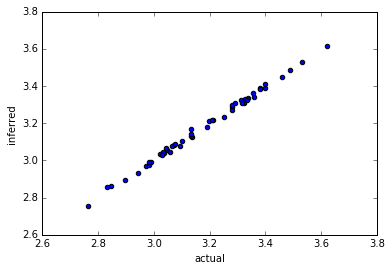

In [30]:
plt.scatter(dA.ravel(), A_init)
plt.xlabel('actual')
plt.ylabel('inferred')

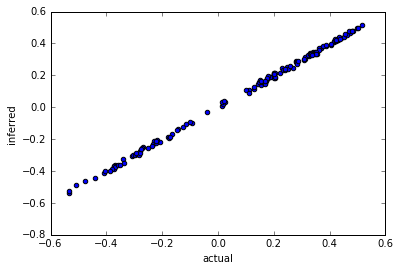

In [31]:
plt.scatter(dB.ravel(), B_init.ravel())
plt.xlabel('actual')
plt.ylabel('inferred')

# Define the model

## Constants

In [32]:
# define some needed constants
N = Xdat.shape[0]  # number of trials

In [33]:
N

100000

## Inputs and data

In [34]:
X = tf.constant(Xdat.astype('float32'))
U = tf.constant(unit)
S = tf.constant(stim)
counts = tf.constant(count)
allinds = tf.constant(np.arange(N))
NSU = tf.constant(pair_counts.astype('float32'))
codes_SU = tf.constant(su_codes)

In [35]:
X.get_shape()

TensorShape([Dimension(100000), Dimension(3)])

Make a node that produces `NB` indices from the range $[0, N - 1]$. These are the subset of data points we want to use.

In [36]:
NB = N
batch_inds = np.arange(N)
batch_counts = counts

## Generative (p) model

In [37]:
with tf.variable_scope("pmodel"):
    muA = ed.models.Normal(mu=np.log(25) * tf.ones(1), sigma=0.5 * tf.ones(1), name='mu_A')
    muB = ed.models.Normal(mu=tf.zeros(P), sigma=0.5 * tf.ones(P), name='mu_B')
    sigA = ed.models.Gamma(alpha=2. * tf.ones(1), beta=4. * tf.ones(1), name='sig_A')
    sigB = ed.models.Gamma(alpha=2. * tf.ones(P), beta=4. * tf.ones(P), name='sig_B')

    A = ed.models.Normal(mu=tf.tile(muA, (NU,)), 
                         sigma=tf.tile(sigA, (NU,)), 
                         name='A')
    B = ed.models.Normal(mu=tf.tile(tf.expand_dims(muB, 0), (NU, 1)), 
                         sigma=tf.tile(tf.expand_dims(sigB, 0), (NU, 1)), 
                         name='B')

    sig = ed.models.Normal(mu=[-7.0], sigma=[1.], name='sig')

    lam_vars = (tf.gather(A, U) + tf.reduce_sum(tf.gather(B, U) * X, 1))
    lam = ed.models.Normal(mu=tf.gather(lam_vars, batch_inds), 
                           sigma=tf.exp(sig), name='lam')

    cnt = ed.models.Poisson(lam=tf.exp(lam), value=tf.ones(NB), name='cnt')

# Recognition (q) model

In [38]:
with tf.variable_scope("qmodel"):
    # population means
    q_muA = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(np.log(25) * tf.ones(1)), 
                                              sigma=tf.Variable(0.5 * tf.ones(1)),
                                              name='mu_A')
    tf.scalar_summary('q_muA', tf.reduce_mean(q_muA.mean()))

    q_muB = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(tf.zeros(P)), 
                                              sigma=tf.Variable(0.5 * tf.ones(P)),
                                              name='mu_B')
    tf.scalar_summary('q_muB', tf.reduce_mean(q_muB.mean()))


    # population standard deviations
    q_sigA = ed.models.GammaWithSoftplusAlphaBeta(alpha=tf.Variable(2. * tf.ones(1)), 
                                                  beta=tf.Variable(4. * tf.ones(1)),
                                                  name='sig_A')
    tf.scalar_summary('q_sigA', tf.reduce_mean(q_sigA.mean()))

    q_sigB = ed.models.GammaWithSoftplusAlphaBeta(alpha=tf.Variable(2. * tf.ones(P)), 
                                                  beta=tf.Variable(4. * tf.ones(P)),
                                                  name='sig_B')
    tf.scalar_summary('q_sigB', tf.reduce_mean(q_sigB.mean()))

    
    # individual unit coefficients
    q_A = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(np.log(25) + tf.random_normal((NU,))), 
                                            sigma=tf.Variable(0.5 + tf.random_uniform((NU,))),
                                            name='A')
    tf.scalar_summary('q_A', tf.reduce_mean(q_A.mean()))

    q_B = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(tf.random_normal((NU, P))), 
                                            sigma=tf.Variable(0.5 + tf.random_uniform((NU, P))),
                                            name='B')
    tf.scalar_summary('q_B', tf.reduce_mean(q_B.mean()))

    # log firing rates
    lam_mu = tf.Variable(2 + tf.random_normal((N,)))
    tf.scalar_summary('lam_mu_mean', tf.reduce_mean(tf.gather(lam_mu, batch_inds)))
    lam_sig = tf.Variable(3 * tf.random_uniform((N,)) + 2)
    q_lam = ed.models.NormalWithSoftplusSigma(mu=tf.gather(lam_mu, batch_inds),
                                              sigma=tf.gather(lam_sig, batch_inds),
                                              name='lam')

    q_sig = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(-0.1 * tf.random_uniform((1,))),
                                              sigma=tf.Variable(tf.random_uniform((1,))),
                                              name='sig')

# ELBO

In [39]:
def make_ELBO(latent_vars, data, scale):
    from edward.util import copy
    p_log_prob = 0.0
    q_log_prob = 0.0
    z_sample = {}
    scope = "ELBO"

    for z, qz in latent_vars.items():
        # Copy q(z) to obtain new set of posterior samples.
        qz_copy = copy(qz, scope=scope)
        z_sample[z] = qz_copy.value()
        z_log_prob = tf.reduce_sum(qz.log_prob(tf.stop_gradient(z_sample[z])))
        if z in scale:
            z_log_prob *= scale[z]

        q_log_prob += z_log_prob

    dict_swap = z_sample
    for x, qx in data.items():
        if isinstance(x, ed.RandomVariable):
            if isinstance(qx, ed.RandomVariable):
                qx_copy = copy(qx, scope=scope)
                dict_swap[x] = qx_copy.value()
            else:
                dict_swap[x] = qx

            for z in latent_vars.keys():
                z_copy = copy(z, dict_swap, scope=scope)
                z_log_prob = tf.reduce_sum(z_copy.log_prob(dict_swap[z]))
                if z in scale:
                    z_log_prob *= scale[z]

                p_log_prob += z_log_prob

            for x in data.keys():
                if isinstance(x, ed.RandomVariable):
                    x_copy = copy(x, dict_swap, scope=scope)
                    x_log_prob = tf.reduce_sum(x_copy.log_prob(dict_swap[x]))
                if x in scale:
                    x_log_prob *= scale[x]

                p_log_prob += x_log_prob

    return tf.reduce_mean(p_log_prob - q_log_prob)

In [40]:
elbo = make_ELBO({A: q_A, B: q_B, 
                  muA: q_muA, muB: q_muB, 
                  sigA: q_sigA, sigB: q_sigB,
                  sig: q_sig, lam: q_lam}, 
                 {cnt: tf.cast(batch_counts, 'float32')}, 
                 {lam: N/NB, cnt: N/NB})

tf.scalar_summary('ELBO', elbo)

<tf.Tensor 'ScalarSummary:0' shape=() dtype=string>

# Do variational inference

In [41]:
inference_lam = ed.KLqp({lam: q_lam, sig: q_sig}, 
                        data={cnt: batch_counts, 
                              A: q_A, B: q_B,
                              muA: q_muA, muB: q_muB,
                              sigA: q_sigA, sigB: q_sigB})
inference_coeffs = ed.KLqp({A: q_A, B: q_B}, 
                           data={cnt: batch_counts, 
                                 lam: q_lam, sig: q_sig,
                                 muA: q_muA, muB: q_muB,
                                 sigA: q_sigA, sigB: q_sigB})
inference_pop = ed.KLqp({muA: q_muA, muB: q_muB,
                        sigA: q_sigA, sigB: q_sigB},
                        data={cnt: batch_counts, 
                             lam: q_lam, sig: q_sig,
                             A: q_A, B: q_B})

# Notes on inference:

- The `logdir` keyword specifies the place to put the log file (assuming you've instrumented the code to save events, etc.). If a subdirectory is given, pointing Tensorboard at the parent directory allows you to compare across subdirectories (runs).
    - ~~I'm using the `jmp/instrumented` branch of the `jmxpearson/edward` fork~~ No longer needed after Edward PR merged.
- The learning rate is a difficult tradeoff: 1e-2 drastically speeds convergence but can run into NaNs; 1e-3 (the default) is much slower.
    - **TO DO**: Does regularizing emergence of `NaN`s help with this?
    - **Update**: I had to hack TF's implementation of `Beta` to include fudge factors in `logp` and a couple of other places in order to remove NaNs.
- I'm currently using "all" the data, which appears to be faster (run-time, wise) than using minibatches. (Not entirely sure why this is, except perhaps that switching data into and out of the graph has a cost.) I've also found that minibatches need to be fairly substantial to be effective, since most variables ($\lambda$, $A$, $B$, $C$) are unit-specific (i.e., local), so unless you have several observations from that unit, convergence can be slow.
    - Ultimately, it might speed things to have a smarter minibatch selection (i.e., all observations for a single unit) when updating the local variables.
- I've used `n_samples` = 1, 5, 10, and 25, which all seem pretty similar after 10k iterations.
    - Follow-up: since adding explicit (non-gradient) optimization steps, this may be moot, since those update operations aren't code to handle multiple samples. Would need `tf.reduce*` sprinkled here and there to work.
- I've noticed no difference below in how many steps one takes along each coordinate before switching (number of inner loop iterations), either in runtime or convergence. Perhaps this matters in the final stages, but I would suspect that then it favors tighter inner loops.
- As per Edward documentation and my own experience: it really helps to have separate updates for "local" and "global" variables. This is why $\lambda$ and $(A, B, C)$ are updated separately. Same idea with the hierarchy.
- Updating the discrete pieces ($Z$ and $\pi$) was terrible. This is most likely because the minima for $Z$ are all near 0 and 1, and it's very hard to get there without making large moves.

In [42]:
# Initialize each (Edward) inference step
debug = False
inf_list = [inference_lam, inference_coeffs, inference_pop]

for inf in inf_list:
    if inf is inference_lam:
        logdir = 'data/run7'
    else:
        logdir = None
        
    inf.initialize(n_print=100, n_samples=1,  
                  logdir=logdir,
                  optimizer=tf.train.AdamOptimizer(1e-3),
                  scale={lam: N/NB, cnt: N/NB},
                  debug=debug)

In [43]:
init = tf.initialize_all_variables()
init.run({})

# If you get `NaN`s...
![learning rate advice](1jseeo.jpg)

In [59]:
n_iter = 60000
sess = tf.get_default_session()
for _ in range(n_iter):
    for inf in inf_list:
        for _ in range(1):  # make multiple steps along each set of coords
            info_dict = inf.update()
        if inf is inference_lam:
            inf.print_progress(info_dict)

Iteration 120100 [12010%]: Loss = 315817.562
Iteration 120200 [12020%]: Loss = 313728.219
Iteration 120300 [12030%]: Loss = 313495.438
Iteration 120400 [12040%]: Loss = 314012.406
Iteration 120500 [12050%]: Loss = 314472.625
Iteration 120600 [12060%]: Loss = 334021.469
Iteration 120700 [12070%]: Loss = 316908.625
Iteration 120800 [12080%]: Loss = 312098.062
Iteration 120900 [12090%]: Loss = 312963.156
Iteration 121000 [12100%]: Loss = 311995.938
Iteration 121100 [12110%]: Loss = 317672.500
Iteration 121200 [12120%]: Loss = 313251.562
Iteration 121300 [12130%]: Loss = 311728.500
Iteration 121400 [12140%]: Loss = 313106.812
Iteration 121500 [12150%]: Loss = 314042.438
Iteration 121600 [12160%]: Loss = 311489.438
Iteration 121700 [12170%]: Loss = 311375.906
Iteration 121800 [12180%]: Loss = 310852.625
Iteration 121900 [12190%]: Loss = 312992.188
Iteration 122000 [12200%]: Loss = 311639.969
Iteration 122100 [12210%]: Loss = 312603.531
Iteration 122200 [12220%]: Loss = 314528.125
Iteration 

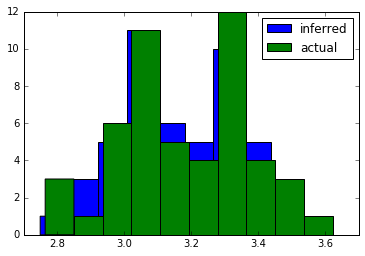

In [60]:
plt.hist(q_A.mean().eval().ravel(), label='inferred'); plt.hist(dA.ravel(), label='actual'), plt.legend();

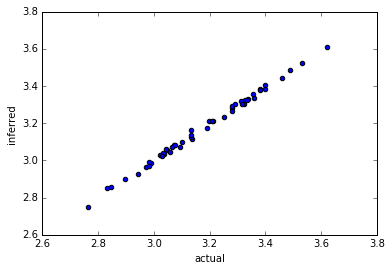

In [61]:
plt.scatter(dA.ravel(), q_A.mean().eval().ravel())
plt.xlabel('actual')
plt.ylabel('inferred')

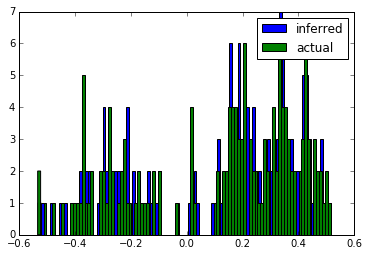

In [62]:
plt.hist(q_B.mean().eval().ravel(), 100, label='inferred'), plt.hist(dB.ravel(), 100, label='actual'), plt.legend();

In [63]:
dB.mean(0), dB.std(0)

(array([-0.2743171 ,  0.19381299,  0.39316082]),
 array([ 0.1278376 ,  0.07357212,  0.06326519]))

In [64]:
q_B.mean().eval().mean(0), q_B.mean().eval().std(0)

(array([-0.27179265,  0.19465165,  0.39175063], dtype=float32),
 array([ 0.12693614,  0.07359245,  0.06307648], dtype=float32))

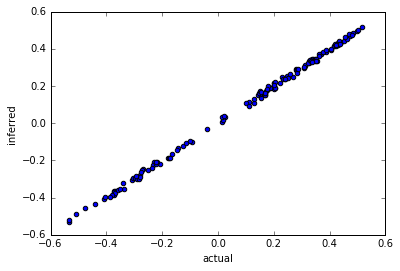

In [65]:
plt.scatter(dB.ravel(), q_B.mean().eval().ravel())
plt.xlabel('actual')
plt.ylabel('inferred')

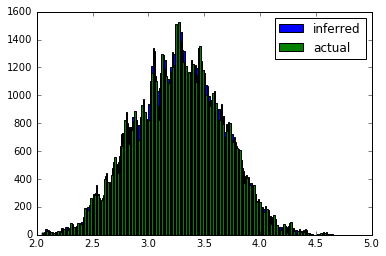

In [66]:
plt.hist(lam_mu.eval(), 200, label='inferred'), plt.hist(dlam, 200, label='actual'), plt.legend();

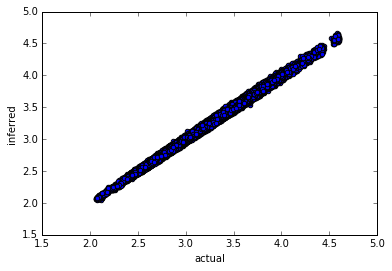

In [67]:
plt.scatter(dlam.ravel(), lam_mu.eval().ravel())
plt.xlabel('actual')
plt.ylabel('inferred')

In [68]:
lam_mu.value().eval()

array([ 3.33127856,  3.24298263,  2.90826464, ...,  3.9010663 ,
        3.92955494,  3.53663588], dtype=float32)

In [69]:
q_lam.mean().eval()

array([ 3.33127856,  3.24298263,  2.90826464, ...,  3.9010663 ,
        3.92955494,  3.53663588], dtype=float32)

In [70]:
q_sig.mean().eval()

array([-2.72199321], dtype=float32)

In [71]:
q_muA.mean().eval(), np.log(25)

(array([ 2.78020024], dtype=float32), 3.2188758248682006)

In [72]:
q_muB.mean().eval()

array([-0.24020737,  0.08001974,  0.47328213], dtype=float32)

In [73]:
q_B.mean().eval().mean(0)

array([-0.27179265,  0.19465165,  0.39175063], dtype=float32)

In [74]:
sig.mean().eval(), np.exp(q_sig.mean().eval())

(array([-7.], dtype=float32), array([ 0.06574358], dtype=float32))